In [1]:
# notebook last tested with abtem version 1.0.0beta25

from abtem import __version__
print('current version:', __version__)

import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
from gpaw import GPAW

from abtem import Probe, show_atoms, PixelatedDetector, GridScan
from abtem.dft import GPAWPotential
from abtem.reconstruct import epie


Bad key "text.kerning_factor" on line 4 in
/home/jacob/miniconda3/envs/abtem/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


current version: 1.0.0beta25


# 4D-STEM simulation with GPAW potential

We start by running our DFT calculation. If you are simulating a large structure, requiring an expensive DFT calculation, you should probably import the GPAW calculator, instead of running the calculation in the notebook. 

In [2]:
# Need converged calculator, this would usually be imported

atoms = read('../data/hexagonal_graphene.cif')

gpaw = GPAW(h=.1, txt=None, kpts=(3,3,1))
atoms.calc = gpaw
atoms.get_potential_energy()

-19.684561299912964

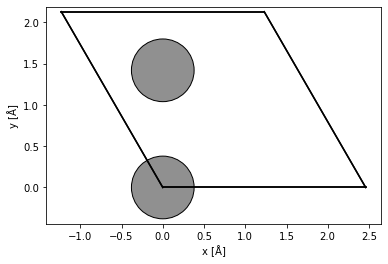

In [3]:
show_atoms(atoms)

We create the potential. Note, that abTEM requires a potential with orthogonal lattice vectors, hence, abTEM will attempt to make potential orthogonal. This is not always trivial, so some structures might require additional work.

We tile the potential, to improve the Fourier space sampling and to ensure a more uniform Fourier space sampling (we want a square potential, although that may not always be possible).

In [4]:
potential = GPAWPotential(gpaw, sampling=.03).build()

repetitions = (3,2)

potential = potential.tile(repetitions)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f7c423e1b20>,
 <matplotlib.image.AxesImage at 0x7f7c423aeee0>)

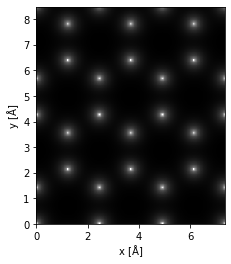

In [5]:
potential.project().show()

We create the probe and show it.

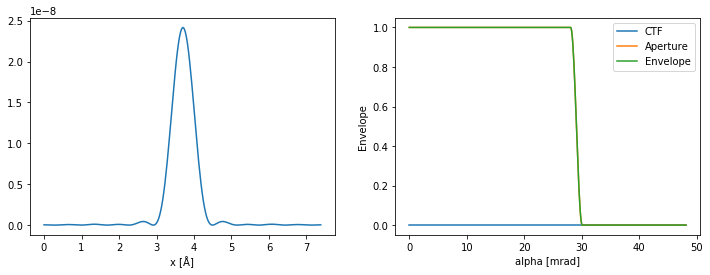

In [6]:
probe = Probe(energy=100e3, semiangle_cutoff=30)

probe.grid.match(potential)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
probe.profile().show(ax=ax1);
probe.ctf.show(ax=ax2);

We create the detector, here we set set maximum detected angle to 60 mrad, in addition we use the resampling option to downsample in Fourier space to match some particular detector specification.

In [29]:
detector = PixelatedDetector(resample=(5,5))

Note, that downsampling should be prefered, i.e. you should repeat the potential enough such that the simulated sampling is better than the resampling. You can get the simulated angular sampling as below:

In [30]:
probe.angular_sampling

(5.015496663588848, 4.343547389074797)

In [31]:
scan_end = (potential.extent[0], potential.extent[1])

gridscan = GridScan(start=[0, 0], end=scan_end, sampling=probe.ctf.nyquist_sampling * .9)

measurement = probe.scan(gridscan, detector, potential)

Scan:   0%|          | 0/837 [00:00<?, ?it/s]

We can add sptial partial incoherence as below

In [32]:
source_size = .25 # FWHM source size (other sources of partial spatial incoherence may contribute)

measurement_spatial = measurement.gaussian_filter((source_size / 2.355,) * 2 + (0.,) * 2)

We can show individual diffraction patterns...

(<matplotlib.axes._subplots.AxesSubplot at 0x7f7c424c4520>,
 <matplotlib.image.AxesImage at 0x7f7c424c45b0>)

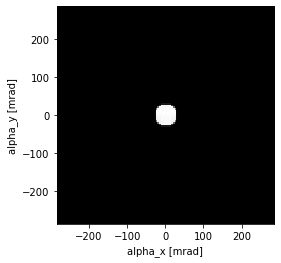

In [33]:
measurement_spatial[0,5].show()

and run some of abTEM's builtin analysis algorithms. Such as center of mass calculations

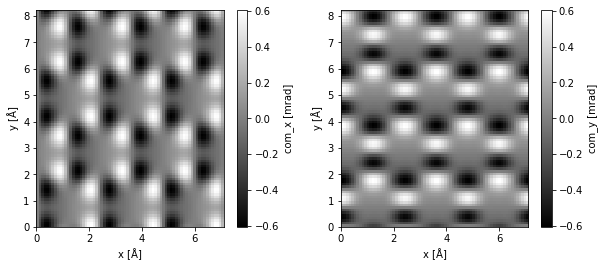

In [34]:
from abtem.measure import center_of_mass

com_x, com_y = center_of_mass(measurement_spatial)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

com_x.interpolate(.1).show(ax=ax1, cbar=True)
com_y.interpolate(.1).show(ax=ax2, cbar=True);

... or phase recutruction using ePIE

In [ ]:
reconstruction = epie(measurement_spatial, probe, maxiter=20, alpha=.5, beta=.5, fix_com=True)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

In [ ]:
reconstruction[0].angle().show()